<b>FACTS: </b><br>
Number of images in training set: N = 416 <br>
Number of Pixels per image: D = 2576 <br>
Number of classes: c = 52 <br>
-> <br>
Sw: rank(Sw)= N-c = 364 -> Mpca <= 364 <br>
Sb: rank(Sb)= c-1 = 51 -> Mlda <= 51 <br>

In [1]:
# Imports
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
# Load the training and testing sets: 80% is training, 20% is testing

splittype = 'class'

if (splittype == 'whole'):
    training = np.loadtxt('split_whole_train.gzip', dtype = 'uint8')
    test = np.loadtxt('split_whole_test.gzip', dtype = 'uint8')
elif (splittype == 'class'):
    training = np.loadtxt('split_class_train.gzip', dtype = 'uint8')
    test = np.loadtxt('split_class_test.gzip', dtype = 'uint8')

In [3]:
# Define constants
TRAIN_RATIO = 0.8
CLASS_SIZE = 52 # number of classes
PIC_DIM = (46,56) # dimensions of picture
PIC_SIZE = PIC_DIM[0]*PIC_DIM[1]

# Divide the data set into training and testing sets: 80% is training, 20% is testing
TRAIN_SIZE = training.shape[0]
TEST_SIZE = test.shape[0]

training, testing: axis 0: pictures, axis 1: pixels + label

In the following cell we calculate the an <b> individual array for each class, the mean vector for each class and the global mean. <b>

In [4]:
# Order training data depending on their class
training = training[np.argsort(training[:,-1]),:]

# Create a list of arrays depending on the classes
class_sets = []
for i in range(CLASS_SIZE):
    class_sets.append(training[i==(training[:,-1]-1),:PIC_SIZE]) # dimensions: numbers of pictures in each class x PIC_SIZE

# Calculate the mean vector of each class
class_means = np.zeros((CLASS_SIZE,PIC_SIZE))
for i in range(CLASS_SIZE):
    class_means[i,:] = np.mean(class_sets[i], axis=0)

# Calculate the global mean
global_mean = np.mean(training[:,:PIC_SIZE], axis=0)

<b>S<sub>B</sub> matrix</b>

RANK OF Sb: 51


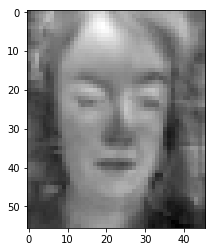

In [5]:
# Compute Sb
class_means_norm = class_means - global_mean # make use of broadcasting
Sb = np.dot(class_means_norm.T, class_means_norm)

plt.imshow(np.reshape(class_means_norm[1,:], PIC_DIM).T, cmap = 'gist_gray')

print("RANK OF Sb:", np.linalg.matrix_rank(Sb)) # =c-1

<b>x-m<sub>i</sub> and S<sub>W</sub> matrix</b>

RANK OF Sw: 364
SIZE OF Sw: (2576, 2576)


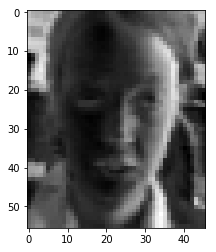

In [6]:
# Compute x-mi
class_sets_norm = []
for i in range(CLASS_SIZE):
    class_sets_norm.append(class_sets[i]-class_means[i,:])

plt.imshow(np.reshape(class_sets_norm[1][2,:], PIC_DIM).T, cmap = 'gist_gray')

# Compute Sw
Sw = np.zeros((PIC_SIZE,PIC_SIZE))
for c in class_sets_norm:
    Sw += np.dot(c.T,c)
    
print("RANK OF Sw:", np.linalg.matrix_rank(Sw)) # = N-c
print("SIZE OF Sw:", Sw.shape)

<b>S<sub>T</sub> matrix</b>

In [7]:
# Compute St (total scatter matrix)
# Images are represented as rows of the array 'pca_train'
#train_pic = training [:, :PIC_SIZE]
#train_pic_norm = train_pic - global_mean
#St = np.dot(train_pic_norm.T, train_pic_norm)

#print("RANK OF St:", np.linalg.matrix_rank(St)) # = N-1

In [8]:
# Compute St (use low-dimensional computation of eigenspace)
# Images are represented as rows of the array 'pca_train'
train_pic = training [:, :PIC_SIZE]
train_pic_norm = train_pic - global_mean
St = np.dot(train_pic_norm, train_pic_norm.T)

print("RANK OF St:", np.linalg.matrix_rank(St)) # = N-1

RANK OF St: 415


<b>W<sub>pca</sub> matrix</b>

SIZE OF Wpca: (2576, 190)
RANK OF Wpca: 190


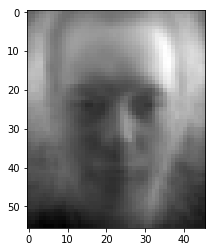

In [9]:
# Compute Wpca
# Find the eigenvalues of the St matrix
eigvals_St, eigvecs_St = np.linalg.eig(St)

# Take the real part of the eigenvalues (complex eigenvalues are the result of numerical rounding errors)
eigvals_St = np.real(eigvals_St)
# Take the real part and calculate the eigenvectors of the matrix A*A_T
eigvecs_St = train_pic_norm.T.dot(np.real(eigvecs_St))
eigvecs_St = eigvecs_St / np.linalg.norm(eigvecs_St,axis=0)

# Order eigenvectors and eigenvalues according to their size
index_St = (abs(eigvals_St)).argsort()[::-1]
eigvals_St = eigvals_St[index_St]
eigvecs_St = eigvecs_St[:,index_St]

# We just keep the first Mpca eigenvectors and eigenvalues
Mpca = 190 #<=364
eigvecs_St_best = eigvecs_St[:, :Mpca]
eigvals_St_best = eigvals_St[:Mpca]

#Define Wpca
Wpca = eigvecs_St_best

print("SIZE OF Wpca:", Wpca.shape)
print("RANK OF Wpca:", np.linalg.matrix_rank(Wpca))
plt.imshow(np.reshape(Wpca[:,0], PIC_DIM).T, cmap = 'gist_gray')

<b>W<sub>lda</sub> matrix</b>

RANK OF LDA_inverse: 51
[ 3.28331504e+00  2.73811279e+00  2.14286292e+00  1.71550025e+00
  1.56347046e+00  1.52347983e+00  1.35513613e+00  1.27994702e+00
  1.21331626e+00  1.13072433e+00  1.07905558e+00  9.36072378e-01
  8.75075613e-01  7.77769676e-01  7.36512467e-01  6.53141271e-01
  6.30242831e-01  5.96180861e-01  5.41562967e-01  5.10236981e-01
  4.85418043e-01  4.45122376e-01  4.20675948e-01  3.92340955e-01
  3.76227090e-01  3.42906651e-01  3.21474570e-01  3.02194424e-01
  2.97944172e-01  2.75032531e-01  2.74375333e-01  2.51803089e-01
  2.28490513e-01  2.19031660e-01  2.06314789e-01  1.95483377e-01
  1.80670335e-01  1.65983907e-01  1.52088871e-01  1.42642999e-01
  1.34769853e-01  1.27407433e-01  1.17495731e-01  1.08030584e-01
  1.02728005e-01  9.32082596e-02  8.50871846e-02  8.27824212e-02
  6.73800269e-02  6.35737615e-02  4.92777410e-02 -7.69961370e-16
  6.77210378e-16 -4.44580265e-16 -3.97324650e-16 -3.97324650e-16
  3.44600163e-16  3.44600163e-16  3.37449233e-16  3.37449233e-16
 

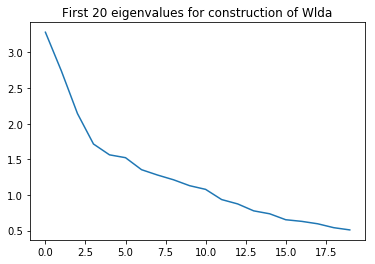

SIZE OF Wlda: (190, 51)
RANK OF Wlda: 51


In [21]:
# Compute inverse of Sw_reduced times Sb_reduced
LDA_inverse = np.linalg.inv(Wpca.T.dot(Sw).dot(Wpca)).dot(Wpca.T.dot(Sb).dot(Wpca))
print("RANK OF LDA_inverse:", np.linalg.matrix_rank(LDA_inverse))

# Compute Wlda
# Get the generalised eigenvectors of LDA_matrix with largest Mlda eigenvalues
eigvals_LDA, eigvecs_LDA = np.linalg.eig(LDA_inverse)

# Take real part of the eigenvalues (complex eigenvalues are the result of numerical rounding errors)
eigvals_LDA = np.real(eigvals_LDA)
eigvecs_LDA = np.real(eigvecs_LDA)

# Order eigenvectors and eigenvalues according to their size
index_LDA = (abs(eigvals_LDA)).argsort()[::-1]
eigvals_LDA = eigvals_LDA[index_LDA]
eigvecs_LDA = eigvecs_LDA[:,index_LDA]

print(eigvals_LDA)

# Plot them
plt.plot(np.arange(0, 20), eigvals_LDA[:20])
plt.title('First 20 eigenvalues for construction of Wlda')
plt.show()

# We just keep the first Mlda eigenvectors and eigenvalues
Mlda = 51 #<=51
eigvecs_LDA_best = eigvecs_LDA[:, :Mlda]
eigvals_LDA_best = eigvals_LDA[:Mlda]

# Define Wlda
Wlda = eigvecs_LDA_best

print("SIZE OF Wlda:", Wlda.shape)
print("RANK OF Wlda:", np.linalg.matrix_rank(Wlda))

<b>W<sub>opt</sub> matrix</b>

SIZE OF Wopt: (2576, 51)
RANK OF Wopt: 51
Fisherface example:


(Text(0.5,1,'Third Fisherface'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

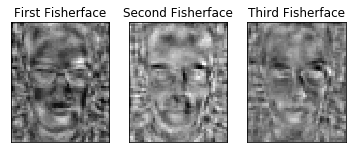

In [11]:
# Compute Wopt
Wopt_transposed = Wlda.T.dot(Wpca.T)
Wopt = Wopt_transposed.T

print("SIZE OF Wopt:", Wopt.shape)
print("RANK OF Wopt:", np.linalg.matrix_rank(Wlda))

print("Fisherface example:")
plt.subplot(131),plt.imshow(np.reshape(Wopt[:,0], PIC_DIM).T, cmap = 'gist_gray')
plt.title('First Fisherface'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(np.reshape(Wopt[:,1], PIC_DIM).T, cmap = 'gist_gray')
plt.title('Second Fisherface'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(np.reshape(Wopt[:,2], PIC_DIM).T, cmap = 'gist_gray')
plt.title('Third Fisherface'), plt.xticks([]), plt.yticks([])

<b> Reconstruction check

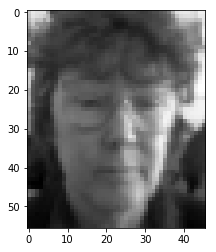

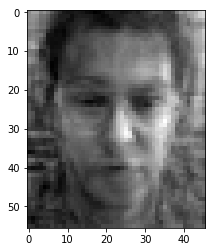

In [12]:
#Reconstruction check
plt.imshow(np.reshape(train_pic[0,:], PIC_DIM).T, cmap = 'gist_gray')
LDA_pic = Wopt_transposed.dot((train_pic[0,:]-global_mean))
LDA_reconstructed_pic = Wopt.dot(LDA_pic)+global_mean
plt.figure()
plt.imshow(np.reshape(LDA_reconstructed_pic, PIC_DIM).T, cmap = 'gist_gray')

<b>PCA-LDA based face recognition with the NN classifier

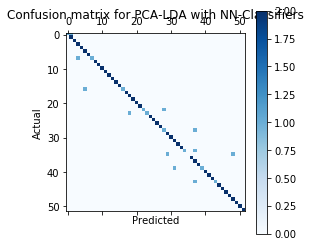

Prediction Accuracy: 0.8942307692307693


In [13]:
#Predict the classes of the test set with PCA-LDA and NN-classifier

#Project training data into LDA space
train_LDA = Wopt_transposed.dot(train_pic_norm.T) # each picture is represented by a column

#Project test data into LDA space
test_norm = (test[:,:PIC_SIZE] - global_mean)
test_LDA = Wopt_transposed.dot(test_norm.T) #each picture is represented by a column

# Reshape and repeat matrices to allow easier manipulation
train_LDA_reshape_NN = np.repeat(train_LDA.reshape(Mlda,TRAIN_SIZE,1),TEST_SIZE, axis=2) #afterwards: axis-0: projected values, axis-1: training pictures, axis-2: repeated values
test_LDA_reshape_NN = np.repeat(test_LDA.reshape(Mlda,1,TEST_SIZE), TRAIN_SIZE, axis=1) #afterwards: axis-0: projected values, axis-1: repeated values, axis-2: test pictures

# Compute nearest neighbours
LDA_distances = np.linalg.norm(test_LDA_reshape_NN-train_LDA_reshape_NN, axis=0) # axis-0: training picture, axis-1: test picture

# Determine the nearest training picture
nearest_trainpic = LDA_distances.argmin(axis=0)

# Determine the nearest classes
classes_pred_NN = training[nearest_trainpic,PIC_SIZE]
classes_act_NN = test[:,PIC_SIZE]

# Print the corresponding confusion matrix
cm_PCA_LDA_NN = confusion_matrix(classes_act_NN, classes_pred_NN)

plt.matshow(cm_PCA_LDA_NN, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix for PCA-LDA with NN-Classifiers')
plt.show()

# Determine the prediction accuracy
accuracy_PCA_LDA_NN = np.sum(classes_pred_NN==classes_act_NN) / classes_act_NN.shape[0]
print("Prediction Accuracy:",accuracy_PCA_LDA_NN)


<b>PCA-LDA based face recognition with Average NN classifier

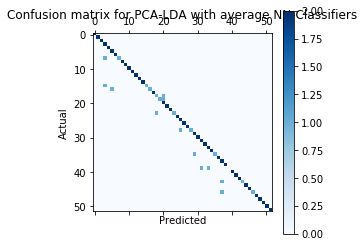

Prediction Accuracy: 0.8846153846153846


In [14]:
# Predict the classes of the test set with PCA-LDA and average NN-classifier

# Project all classes into the LDA-Space individually
class_sets_LDA = []
for c in class_sets:
    class_sets_LDA.append(Wopt_transposed.dot((c-global_mean).T))

# Compute the average distance to the class
class_mean_distance = np.zeros((CLASS_SIZE,TEST_SIZE))
# class_mean_distance is a list of matrices where each element of a matrix stores the mean distance from a test point to all points of a certain class
# axis-0: classes, axis-1: mean distance for each point
for i in range(CLASS_SIZE):
    train_LDA_reshape_NN_av = np.repeat(class_sets_LDA[i].reshape(Mlda,class_sets_LDA[i].shape[1],1),TEST_SIZE,axis=2)
    test_LDA_reshape_NN_av = np.repeat(test_LDA.reshape(Mlda,1,TEST_SIZE), class_sets_LDA[i].shape[1], axis=1)
    d = np.linalg.norm(test_LDA_reshape_NN_av-train_LDA_reshape_NN_av, axis=0)
    class_mean_distance[i,:]=np.average(d,axis=0)
    
# Determine the nearest classes for each testpoint
classes_pred_NN_av = class_mean_distance.argmin(axis=0)+1 # python index starts from 0 -> add 1
classes_act_NN_av = test[:,PIC_SIZE]

# Print the corresponding confusion matrix
cm_PCA_LDA_NN_av = confusion_matrix(classes_act_NN_av, classes_pred_NN_av)

plt.matshow(cm_PCA_LDA_NN_av, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix for PCA-LDA with average NN-Classifiers')
plt.show()

# Determine the prediction accuracy
accuracy_PCA_LDA_NN_av = np.sum(classes_pred_NN_av==classes_act_NN_av) / classes_act_NN_av.shape[0]
print("Prediction Accuracy:",accuracy_PCA_LDA_NN_av)

# Vary M<sub>pca</sub> and M<sub>lda</sub>

In [15]:
Mpca_set = np.array([1,2,3,5,8,12,18,25,35,50,70,90,110,130,150,190,230,270,310,350,364])
Mlda_set = np.array([1,2,3,4,5,7,10,15,20,25,30,35,40,45,51])

In [16]:
def Get_Wopt(PCA, LDA):
    # Take the best PCA eigenvalues of St for computing Wpca_t
    eigvecs_St_best_t = eigvecs_St[:, :PCA]
    eigvals_St_best_t = eigvals_St[:PCA]

    #Define Wpca_t
    Wpca_t = eigvecs_St_best_t
    
    # Compute inverse of Sw_reduced times Sb_reduced
    LDA_inverse_t = np.linalg.inv(Wpca_t.T.dot(Sw).dot(Wpca_t)).dot(Wpca_t.T.dot(Sb).dot(Wpca_t))

    # Compute Wlda
    # Get the generalised eigenvectors of LDA_matrix with largest LDA eigenvalues
    eigvals_LDA_t, eigvecs_LDA_t = np.linalg.eig(LDA_inverse_t)

    # Take real part of the eigenvalues (complex eigenvalues are the result of numerical rounding errors)
    eigvals_LDA_t = np.real(eigvals_LDA_t)
    eigvecs_LDA_t = np.real(eigvecs_LDA_t)

    # Order eigenvectors and eigenvalues according to their size
    index_LDA_t = (abs(eigvals_LDA_t)).argsort()[::-1]
    eigvals_LDA_t = eigvals_LDA_t[index_LDA_t]
    eigvecs_LDA_t = eigvecs_LDA_t[:,index_LDA_t]

    # We just keep the first LDA eigenvectors and eigenvalues
    eigvecs_LDA_best_t = eigvecs_LDA_t[:, :LDA]
    eigvals_LDA_best_t = eigvals_LDA_t[:LDA]

    # Define Wlda
    Wlda_t = eigvecs_LDA_best_t
    
    Wopt_transposed_t = Wlda_t.T.dot(Wpca_t.T)
    return Wopt_transposed_t.T

In [17]:
def Do_PCA_LDA_NN(Wopt_t, LDA):
    #Project training data into LDA space
    train_LDA_t = Wopt_t.T.dot(train_pic_norm.T) # each picture is represented by a column

    #Project test data into LDA space
    test_norm_t = (test[:,:PIC_SIZE] - global_mean)
    test_LDA_t = Wopt_t.T.dot(test_norm_t.T) #each picture is represented by a column

    # Reshape and repeat matrices to allow easier manipulation
    train_LDA_reshape_NN_t = np.repeat(train_LDA_t.reshape(LDA,TRAIN_SIZE,1),TEST_SIZE, axis=2) #afterwards: axis-0: projected values, axis-1: training pictures, axis-2: repeated values
    test_LDA_reshape_NN_t = np.repeat(test_LDA_t.reshape(LDA,1,TEST_SIZE), TRAIN_SIZE, axis=1) #afterwards: axis-0: projected values, axis-1: repeated values, axis-2: test pictures

    # Compute nearest neighbours
    LDA_distances_t = np.linalg.norm(test_LDA_reshape_NN_t-train_LDA_reshape_NN_t, axis=0) # axis-0: training picture, axis-1: test picture

    # Determine the nearest training picture
    nearest_trainpic_t = LDA_distances_t.argmin(axis=0)

    # Determine the nearest classes
    classes_pred_NN_t = training[nearest_trainpic_t,PIC_SIZE]

    # Determine the prediction accuracy
    return np.sum(classes_pred_NN_t==classes_act_NN) / classes_act_NN.shape[0]

In [18]:
prediction_accuracies = np.zeros((Mpca_set.shape[0],Mlda_set.shape[0]))

for p in range(Mpca_set.shape[0]):
    for l in range(Mlda_set.shape[0]):
        if Mlda_set[l]<=Mpca_set[p]:
            Wopt_t = Get_Wopt(Mpca_set[p],Mlda_set[l])
            prediction_accuracies[p,l]=Do_PCA_LDA_NN(Wopt_t,Mlda_set[l])
        else:
            Wopt_t = Get_Wopt(Mpca_set[p],Mpca_set[p])
            prediction_accuracies[p,l]=Do_PCA_LDA_NN(Wopt_t,Mpca_set[p])

maximum_indices = np.unravel_index(np.argmax(prediction_accuracies, axis=None), prediction_accuracies.shape)
print("Maximum prediction accuracy:", prediction_accuracies[maximum_indices])
print("Optimum Mpca:", Mpca_set[maximum_indices[0]])
print("Optimum Mlda:", Mlda_set[maximum_indices[1]])

Maximum prediction accuracy: 0.8942307692307693
Optimum Mpca: 190
Optimum Mlda: 51


<b> Plot graphs for accuracy with varying Mlda and Mpca

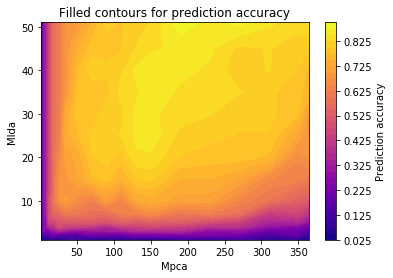

In [19]:
X, Y = np.meshgrid(Mpca_set, Mlda_set)
fig = plt.contourf(X,Y,prediction_accuracies.T, 35, cmap='plasma')
cbar=plt.colorbar()
cbar.set_label('Prediction accuracy', rotation=90)
plt.ylabel('Mlda')
plt.xlabel('Mpca')
plt.title('Filled contours for prediction accuracy')
plt.show()


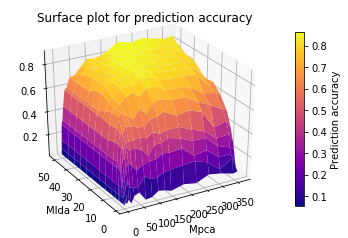

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(X, Y, prediction_accuracies.T, cmap='plasma', color='black' )
plt.ylabel('Mlda')
plt.xlabel('Mpca')
plt.title('Surface plot for prediction accuracy')

# Add a color bar which maps values to colors.
cbar=fig.colorbar(surf, shrink=0.8)
cbar.set_label('Prediction accuracy', rotation=90)
ax.view_init(30, 240)